In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, ScalarFormatter)

from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *  
from radiative import *
from utils import *
from plot_utils import nice_fonts

In [2]:
# Simple check of the S_ff function:
D = 100 * pc
R_star = 1.3 * au
T_star = 2100      # K
R_beam = 0.5 * au  # Beam size, to be updated
T_beam = 3500      # K , measured brightness temperature in the beam with the hot spot

H_hs = R_beam*0.1     # Depth of the hot spot
n_hs = 1e11           # Density of the hot spot

Mdot_dust = 3e-10 # in Msun/yr
vExp = 10         # in km/s
Rin = 5.0         # in au
Rout = 1e6        # in au
kappaFile = "0.09mu-0.11mu_MgFeSiO4_dens_HSD_new.opacity"

def S_Jy(nu_sc, x_hs=0.2):
    nu = nu_sc #* nsc 
    T_hs = calc_T_hs(T_star, T_beam, x_hs)
    return S_ff_withStar(nu=nu, R=R_beam, H=H_hs, D=D, T_s=T_star, T=T_hs, n=n_hs, R_s=R_star)

def S_Jy_abs(nu_sc, x_hs):
    nu = nu_sc #* nsc 
    S_unabs = S_Jy(nu, x_hs)
    return CircumstellarDustExtinction(S_unabs, nu, Mdot_dust, vExp, Rin, Rout, kappaFile)

## Make a plot to check the routines

T_hs=3.7e+04


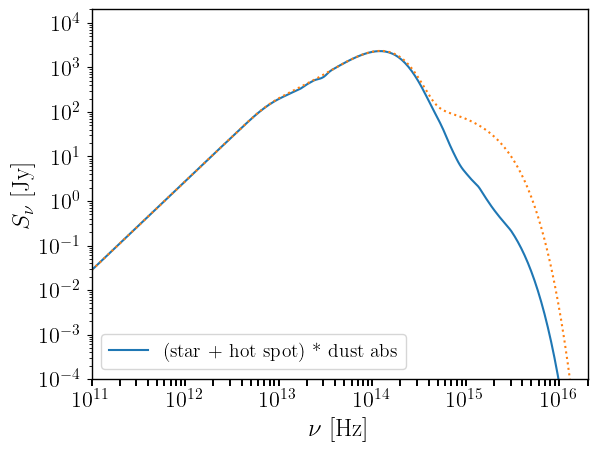

In [3]:
x_hs = 0.2
T_hs = calc_T_hs(T_star, T_beam, x_hs)
print(f'{T_hs=:.1e}')

# Calculate the SED
nu = np.geomspace(1e11,2e16,300) #/nsc

# Plot data and fit
fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.plot(nu, S_Jy_abs(nu, x_hs), label = '(star + hot spot) * dust abs')
plt.plot(nu, S_Jy(nu, x_hs), linestyle=':')
plt.title('')
plt.xlim(nu[0], nu[-1])
plt.ylim(1e-4, 2e4)

plt.legend(loc='best')
ax.loglog()
plt.show()

## Model for R Leo

In [4]:
# The nsc parameter is defined in constants.py
'''nu1 = 1.157e15  # UVW1    
nu2 = 1.345e15  # UVM2 
nu = np.array( [nu1, nu2] ) #/nsc             # Transform to units of 1e15 Hz

flux1 = 1.64e0 * mJy    # in erg/s/cm2/Hz = Jy 
flux1_err = np.sqrt(0.03e0**2 + 0.05e0**2) * mJy  # in erg/s/cm2/Hz

flux2 = 7.97e-2 * mJy   # in erg/s/cm2/Hz 
flux2_err = np.sqrt(0.28e-2**2 + 0.05e-2**2) * mJy # in erg/s/cm2/Hz

print(f'flux1={flux1/mJy} ± {flux1_err/mJy:.2f} mJy')
print(f'flux2={flux2/mJy:.3f} ± {flux2_err/mJy:.3f} mJy')

# The fluxes for fitting will be in Jy, as well as S_Jy
flux = np.array( [flux1, flux2] ) / Jy
flux_err = np.array( [flux1_err, flux2_err] ) / Jy
print(flux, flux_err)

'''

nub = 6e14      # b filter
nuu = 8e14      # u filter
nu1 = 1.157e15  # UVW1    
nu2 = 1.345e15  # UVM2 
nu = np.array( [nub, nuu, nu1, nu2] ) #/nsc             # Transform to units of 1e15 Hz

fluxb = 2000.0 * mJy
fluxu = 200.0 * mJy
fluxb_err = np.sqrt(0.5e0**2 + 0.1e0**2) * mJy  # in erg/s/cm2/Hz
fluxu_err = np.sqrt(0.5e0**2 + 0.1e0**2) * mJy  # in erg/s/cm2/Hz

flux1 = 1.64e0 * mJy    # in erg/s/cm2/Hz = Jy 
flux1_err = np.sqrt(0.03e0**2 + 0.05e0**2) * mJy  # in erg/s/cm2/Hz

flux2 = 7.97e-2 * mJy   # in erg/s/cm2/Hz 
flux2_err = np.sqrt(0.28e-2**2 + 0.05e-2**2) * mJy # in erg/s/cm2/Hz

# The fluxes for fitting will be in Jy, as well as S_Jy
flux = np.array( [fluxb, fluxu, flux1, flux2] ) / Jy
flux_err = np.array( [fluxb_err, fluxu_err, flux1_err, flux2_err] ) / Jy
print(flux, flux_err)

[2.00e+00 2.00e-01 1.64e-03 7.97e-05] [5.09901951e-04 5.09901951e-04 5.83095189e-05 2.84429253e-06]


In [5]:
# Model fitting

# Define seed values for the fit
seed = np.array([0.3]) #  x = R_hs/R_beam
bs = ((0.1), (1.0))     # ( min values, max values ) = ( (min_n, ...), (max_n, ...) )

# Fit function S_ff(nu, R, D, Te, n) to the data  
#popt, pcov = curve_fit( lambda x, logn: S_ff(x,R_s,D,T_e,10**logn), xdata=nu, ydata=S, p0=seed, sigma=S_err, bounds=bs, absolute_sigma=True)
popt, pcov = curve_fit(S_Jy_abs, xdata=nu, ydata=flux, p0=seed, sigma=flux_err, bounds=bs, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

x_fit, x_fit_err = popt[0], perr[0]
x_ufloat = ufloat(x_fit, x_fit_err) 

print(f'x = R_hs/R_beam = {x_ufloat:.2u}')
print(f'T_hs = {calc_T_hs(T_star, T_beam, x_fit):.1e}')


x = R_hs/R_beam = 0.83251+/-0.00012
T_hs = 4.1e+03


In [7]:

#nu_fit = np.geomspace( min(nu)/10.0, max(nu)*5., 100)
nu_fit = np.geomspace( 3e11, 9e16, 200)
fit = S_Jy_abs(nu_fit, x_fit)

SED_star_unabs = S_BB(nu_fit/nsc, R_star, T_star, D)
SED_star =CircumstellarDustExtinction(SED_star_unabs, nu_fit, Mdot_dust, vExp, Rin, Rout, kappaFile)

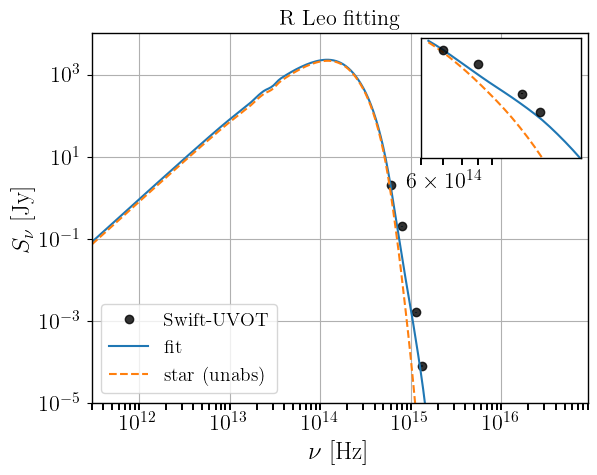

In [8]:
# Plot data and fit
fig, ax = plt.subplots(1)
plt.title('R Leo fitting')
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.xlim(nu_fit[0], nu_fit[-1])
#plt.ylim(min(fit), 1.5*max(fit))
#plt.xlim(2e14, 3e15)
plt.ylim(1e-5, 1e4)
ax.loglog()

plt.errorbar(nu, flux, yerr=flux_err, ecolor='C0', alpha=0.8, fmt='none')
plt.plot(nu, flux, 'ko', alpha=0.8, label = 'Swift-UVOT')

plt.plot(nu_fit, fit, color='C0', linestyle='-', label='fit')
plt.plot(nu_fit, SED_star, linestyle='--', color='C1', label='star (unabs)')

# Display grid lines only at specified ticks
matplotlib.pyplot.grid(True)
plt.legend(loc='lower left')

# Add a subplot in the top right margin
sub_ax = plt.axes([0.64, 0.62, 0.25, 0.25])  # [left, bottom, width, height]
sub_ax.loglog()

# Extract data within the a subrange for a subplot
#nu_in_min, nu_in_max = 1e15, 1.9e15
nu_in_min, nu_in_max = 5e14, 1.9e15
subset_mask = (nu_fit >= nu_in_min) & (nu_fit <= nu_in_max)

# Plot the subset in the subplot
sub_ax.plot(nu_fit[subset_mask], fit[subset_mask], color='C0', linestyle='-')
sub_ax.plot(nu_fit[subset_mask], SED_star[subset_mask], linestyle='--', color='C1')
sub_ax.set_xlim(nu_in_min, nu_in_max)
sub_ax.set_ylim(min(fit[subset_mask]), 1.5 * max(fit[subset_mask]))
sub_ax.errorbar(nu, flux, yerr=flux_err, ecolor='k', alpha=0.8, fmt='none')
sub_ax.plot(nu, flux, 'ko', alpha=0.8)

# Remove x and y ticks from the subplot
sub_ax.set_xticks([])
sub_ax.set_yticks([])

plt.show()